# Coursework 2, Module: *Data Programming in Python DSM020*
## Project Description and Purpose
This study is a follow up project of the Coursework 1 for Data Programming in Python that is done by Şuheyda AKBAY *(2022)*. The link to the Github repository that contains the previous work can be found in the references. This, Coursework 2, aims to extend the analysis of the data that collected in the Coursework 1, which is the data that contains job postings in the field of Data Science in 4 different countries where the daily spoken language is English, using machine learning methods. The data is stored in a comma-separated value file (`jobs.csv`) with the information listed below:
- Job type (full-time, part-time, internship etc.)
- Job function (engineering, information technology, science etc.)
- Business industry (IT services, financial services, management consulting etc.)
- Work level (entry level, director, mid-senior level etc.)
- Work location
- Salary information
- Employer institution

## Imports
To achieve the purpose of this work, it is required to use some of the trending data analysis libraries. External libraries used in this work are:
- `pandas` for handling table based data,
- `matplotlib` for visualizing almost any kind of data,
- `nltk` for preprocessing text data (such as stemming, removing stop words, tokenization),
- `seaborn` for more advanced visualizations (such as box plot and swarm plot),
- `sklearn` for TF-IDF, which is a text vectorization method,
- `tensorflow.keras` for building and fitting deep learning models,
- `bioinfokit` for calculating statically accuracy values.

All the required modules to be able to run the cells in this notebook is listed in the file named `requirements.txt`.

In [ ]:
import requests
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
import nltk.stem
from nltk.collocations import *
import seaborn as sns
from nltk.corpus import stopwords
import sklearn
import tensorflow.keras as keras
import sklearn.cluster
from bioinfokit.analys import stat
import os.path
import unittest

## Loading data
In this section, comma-separated file (`jobs.csv`) that contains the data being analyzed in this work is loaded using `pandas` library. The data will be stored in the memory in a `pandas.DataFrame` object.

In [2]:
if not os.path.exists("jobs.csv"):
    raise Exception("The CSV file that contains job openings is not found")

df = pd.read_csv(
    "jobs.csv",
    usecols=[
        "title",
        "description",
        "salary",
    ],
    index_col=False, # to inform pandas that the CSV file has no index column
    na_values=[""],  # to let pandas replaces missing values with empty strings
)

**Note:** *It is required to shuffle the table before going further to make sure that the data will be distributed homogenously while training the deep learning model later*.

In [3]:
# take the same number of rows but in random order and remove the index
df = df.sample(frac=1).reset_index(drop=True)

## Preprocessing
In this section, the jobs data will be prepared to be analyzed by truncating mismatching rows, pre-processing descriptions and normalizing salary information.

### Filtering by title
In this subsection, the data in the table will be truncated by removing the rows with a value in the title column that is not matching with the list of expected ones. Also, the title value will be replaced with the more specific one.

In [4]:
title_groups = [
    "Data Scientist",
    "Data Analyst",
    "Data Engineer",
]

# returns the title group that is presented in the title value, otherwise returns None
def find_title_group(title):
    for group in title_groups:
        if group in title:
            return group
    return None

# Tests for `find_title_group` function
try:
    assert find_title_group("Senior Data Scientist") == "Data Scientist"
    assert find_title_group("Data Engineer and Data Scientist") == "Data Scientist"
    assert find_title_group("Data") is None
    assert find_title_group("") is None
except:
    raise Exception("Assertion failed for find_title_group function")

In [5]:
# adding a new column in the table for the corresponding title group
df["title_group"] = df["title"].apply(find_title_group)

# removing the rows that has no title that is matching with any title group
df = df[~df["title_group"].isna()]

### Parsing salary values
In this subsection, the salary data in the table is being parsed. The salary data is in form of string that has a currency symbol at the beginning and two numbers (separated with a dash) following the symbol. The first number in the salary data represents the lowest value of the range while the second one represents the highest value. This string that represents the salary value of range is being parsed into numbers and currency unit, and stored into new columns.

In [6]:
# copying salary values into a separate frame, and removing any character except digits, dot or dash from salary column
salary = df['salary'].apply(lambda x: re.sub(r"[^\d\.\-]", "", x))

df = df[~(salary == "")] # removing the rows with an empty salary data

df["salary_min"] = pd.to_numeric(salary.apply(lambda x: x.split("-")[0])) # taking the first number into a new column named "salary_min"
df["salary_max"] = pd.to_numeric(salary.apply(lambda x: x.split("-")[1])) # taking the second number into a new column named "salary_max"

# the part of the salary string until the first digit is being taken into a new column named "salary_unit"
df["salary_unit"] = df['salary'].apply(lambda x: re.split(r"[\d]+", x)[0])

### Normalizing salary values
In this subsection, the values of salary ranges are being converted into a base currency, which is EUR in this case. Before doing this, it is required to have the up to date values of exchange rates of the currencies that are expected to be presented in the data. To fetch the current exchange rates, a public API is used over HTTP protocol.

In [7]:
# lookup table for the symbols per currency codes
currency_symbols = {
    "GBP": "£",
    "USD": "$",
    "EUR": "€",
    "CAD": "CA$",
    "AUD": "A$",
}

# list of expected currency codes
currencies = [
    "GBP",
    "USD",
    "EUR",
    "CAD",
    "AUD",
]

In [8]:
currency_api_key = "e6ce8596b55f74cadf4f61a2c3a91af1" # API key to be authenticated by the provider
currency_url = f"http://api.exchangeratesapi.io/v1/latest" # URL that the GET request will be sent to
currency_result = requests.get( # sending a HTTP/GET request
    currency_url,
    params={ # query parameters:
        "access_key": currency_api_key,
        "symbols": ",".join(currencies), # symbols to have the exchange rates for are expected to be given in a single string
                                        #  and separated by commas.
    },
    timeout=5 # the API endpoint doesn't close the connection, so this is required to close the connection after a certain amount of time
)
if currency_result.status_code != 200:
    raise Exception("The exchange rate API responded with non-200 status code")
exchange_rates = currency_result.json()["rates"] # API endpoint responds with a JSON object that has an object property named "rates"

In [9]:
exchange_rates_by_symbols = dict(
    (currency_symbols[currency], rate)
    for (currency, rate) in exchange_rates.items()
) # a new dict object is built to replace the keys (that has currency codes) with symbols of the currency

In [10]:
# removing the rows that has a salary unit (symbol) which is not presented in the fetched exchange rates
df = df[df["salary_unit"].apply(lambda salary_unit: salary_unit in exchange_rates_by_symbols)]

# "salary_min" and "salary_max" columns are being divided by exchange rate of the related unit
#  and stored in new columns with "norm_" prefix.
df["norm_salary_min"] = df.apply(lambda row: row["salary_min"] / exchange_rates_by_symbols[row["salary_unit"]], axis=1)
df["norm_salary_max"] = df.apply(lambda row: row["salary_max"] / exchange_rates_by_symbols[row["salary_unit"]], axis=1)

# calculating the average of min and max values of the salary range specified in the record.
df["norm_salary_average"] = (df["norm_salary_min"] + df["norm_salary_max"]) / 2

### Truncating by salary average
In this subsection, the boundary of acceptable salary values are calculated by finding lower and upper quantiles of normalized salary average values. Any row with a normalized salary average value out of the acceptible boundary will be removed from the table as they are named as outliers. Also, some of jobs has invalid salary infos that is lower than a thousand, also these rows are deleted.

In [11]:
df = df[df["norm_salary_min"] > 1000] # filter out rows with salary values less than a thousand

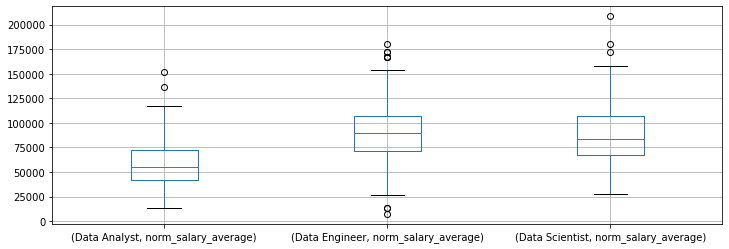

In [12]:
# visualizing boundaries per title groups by box plotting to have an overview
df.groupby("title_group")[['norm_salary_average']].boxplot(subplots=False, figsize=(12, 4))
None

As seen above plots, the table has a few outlier rows. Thus, below, the outlier rows (over normalized salary average) will be removed from the table per each title group separately. So the wishkers for each title group will be calculated separately in a for loop.

In [13]:
for title_group in title_groups: # for each title group
    group_rows = df[df["title_group"] == title_group] # take only the rows related to the title group

    Q1 = group_rows["norm_salary_average"].quantile(0.25) # calculate lower and ...
    Q3 = group_rows["norm_salary_average"].quantile(0.75) #  ... upper quantiles over normaliaed salary average
    IQR = Q3 - Q1 # calculate interquantile range

    # salary boundaries are calculated based on whiskers
    lower_inner_fence = Q1 - 1.5* IQR
    upper_inner_fence = Q3 + 1.5* IQR

    # take the rows that has normalized salary average values outside of the fences
    outliers = group_rows[
        (group_rows["norm_salary_average"] < lower_inner_fence)
        |
        (group_rows["norm_salary_average"] > upper_inner_fence)
    ]

    # remove the outlier rows from the table
    df = df.drop(outliers.index)


### Natural Language Processing
In this subsection, Natural Language Processing (NLP) techniques are applied to the description texts of each rows in the table. The description texts are being vectorized by applying TF-IDF method, just after extracting stopword free n-grams. However, the text must be parsed into tokens before it being able to be processed with the methods mentioned.

In [ ]:
# These NLTK modules downloaded below is required by the library to be able to apply stopword removing, tokenization and TF-IDF
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
None

In [15]:
english_stopwords = stopwords.words('english') # get the list of english stopwords (lower cased)
wordnet = nltk.stem.WordNetLemmatizer() # create an instance of WordNetLemmatizer

# this function takes any text (which must be lower cased) and returns words extracted
#  from stopword removed copy of the text.
def tokenize(text):
    result = list() # an empty list to accumulate words

    text = re.sub(r"[^A-Za-z\s]", " ", text) # removing any character that is not a letter nor space character
    tokens = nltk.word_tokenize(text) # split the text into tokens
    tokens = [token for token in tokens if not token in english_stopwords] # remove tokens that are in the stopword list
    tokens = [wordnet.lemmatize(token) for token in tokens] # replace tokens with their lemmas
    tagged_tokens = nltk.pos_tag(tokens) # tag the tokens
    chunks = nltk.RegexpParser("NounPhrase: {<N.*>+}").parse(tagged_tokens) # group consecutive tokens with noun labels
    for chunk in chunks:
        if isinstance(chunk, nltk.tree.Tree): # take only the noun groups
            words = [token[0] for token in chunk] # each token is a tuple of the word and the label, take only the word
            result.extend(words) # accumulate the result with the words in the chunk

    return result

# NOTE: `tokenize` function will be called by TfidfVectorizer instance internally.

# Unit tests for `tokenize` function
class TokenizeTests(unittest.TestCase):

    def test_func_exists(self):
        self.assertIsNotNone(tokenize)
    
    def test_returns_no_stopword(self):
        self.assertListEqual(tokenize("this is a unit test."), ["unit", "test"])
    
    def test_returns_only_nouns(self):
        self.assertListEqual(tokenize("this unit test passed."), ["unit", "test"])
    
    def test_returns_lemmas(self):
        self.assertListEqual(tokenize("these are unit tests"), ["unit", "test"])

unittest.main(argv=['ingored', '-v'], exit=False)
None

test_func_exists (__main__.TokenizeTests) ... ok
test_returns_lemmas (__main__.TokenizeTests) ... ok
test_returns_no_stopword (__main__.TokenizeTests) ... ok
test_returns_only_nouns (__main__.TokenizeTests) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.829s

OK


Below, the descriptions of each rows in the table will be vectorized using TF-IDF method. For vectorization, an implementation of TF-IDF method will be used, which comes with `sklearn` library. Also the function defined above (`tokenize`) will be passed to the `TfidfVectorizer` instance with the tokenizer parameter. The result of the vectorization will be stored in a variable named `X` as a `numpy` matrix.

In [16]:
# creating a `TfidfVectorizer` instance
description_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    tokenizer = tokenize,
    ngram_range = (1, 4),
    min_df = 0.01, # to filter too rare and ...
    max_df = 0.99, #  ... too common ngrams.
)
# calling `fit_transform` will apply the vectorization and return a implementation specific
#  matrix instance, so it is required to call `toarray` function to convert it into numpy matrix.
X = description_vectorizer.fit_transform(df["description"]).toarray()

In [17]:
ngrams_count = X.shape[1] # first (0) dimension is the number of samples, and the second (1) one is the number of n-grams vectorized
ngrams_count

2646

## Salary Range Prediction

### Building the Model
In this section, the deep learning model will be built. The model will aim to predict minimum and maximum salary values for given job description. For the model, functional model pattern is used since it allows to compose a model with layers that has connections to very previous layers.

The model will have 1 input layer which will have the nodes same number of ngrams, 3 hidden dense layers with 64 nodes per each, and an output dense layer with 2 nodes (one for minimum salary and one for maximum salary). Every dense layer will have connection to all the previous layers including input layer. So with this model of layers, it will be possible to fit the model for even more complex data with relatively less nodes.

While first two dense layers are having **sigmoid** as activation functions, last two dense layers will have **linear** activation functions. Linear activation function at the output layer will allow the model to output values above 1 and in scale of tens of thousands. Sigmoid is the best fit for the first two layers because the input data is scaled between 0 and 1.

`Huber` is used as the loss function because it is a specific loss function that is best for the Y values relatively near to each others. In our case, salary values are mostly distributed between 40,000 and 80,000 while the minimum and maximum ranges are around 20,000 and 120,000, that's why the Y values are *relatively close* to each others.

In [ ]:
input = keras.layers.Input(ngrams_count) # create an input layer

units = 64
dense_0 = keras.layers.Dense(units, activation=keras.activations.sigmoid)( # first dense layer
    input,
)

concat_0 = keras.layers.Concatenate()([
    input,
    dense_0,
])
dense_1 = keras.layers.Dense(units, activation=keras.activations.sigmoid)( # second dense layer
    concat_0,
)

concat_1 = keras.layers.Concatenate()([
    concat_0,
    dense_1,
])
dense_2 = keras.layers.Dense(units, activation=keras.activations.linear)( #third dense layer
    concat_1,
)

concat_2 = keras.layers.Concatenate()([
    concat_1,
    dense_2,
])
dense_3 = keras.layers.Dense(2, activation=keras.activations.linear)( # last dense layer, a.k.a. output layer
    concat_2,
)

salary_model = keras.Model(inputs=input, outputs=dense_3)
salary_model.compile(
    optimizer="sgd",
    loss=keras.losses.huber,
)

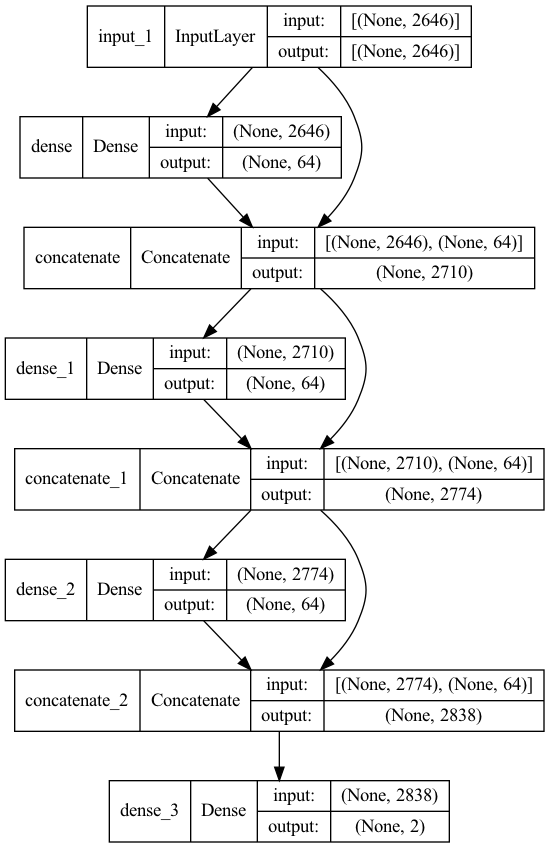

In [19]:
# plotting the model to have an visual overview about the layers.
# this will create (or overwrite if already exists) a file named `salary_model.png`
keras.utils.plot_model(salary_model, show_shapes=True, show_layer_names=True, to_file='salary_model.png')

### Fitting the Model
In this section, the deep learning model that is built for predicting minimum and maximum values of salary for given job description will be fitted. Before going further, `Y` values will be calculated (`X` values are already calculated before building the model). And a number will be calculated that specifies how many of the samples will be used for validation, and how many of them will be used for training (25% is choosen for the ratio of validation split).

In [20]:
Y = df[["norm_salary_min", "norm_salary_max"]].to_numpy() # taking `norm_salary_min` and `norm_salary_max` columns to
                                                          #  produce a Nx2 matrix (N is the number of samples).

In [21]:
val_len = int(len(X) * 0.25) # calculate the number of samples in validation set

In [22]:
history = salary_model.fit(
    X[val_len:], # X of train set
    Y[val_len:], # Y of train set
    validation_data=(
        X[:val_len], # X of validation set
        Y[:val_len], # Y of validation set
    ),
    epochs=25, # decided that 25 epochs were enough to reach a stable value of losses, after testing different number of epochs
    batch_size=64,
)

2022-03-19 00:26:25.770845: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-19 00:26:25.901663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/25
12/12 [==============================] - 0s 20ms/step - loss: 80105.8047 - val_loss: 82925.1250
Epoch 2/25
12/12 [==============================] - 0s 9ms/step - loss: 80103.5391 - val_loss: 82922.7266
Epoch 3/25
 1/12 [=>............................] - ETA: 0s - loss: 75235.6406

2022-03-19 00:26:26.212897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 9ms/step - loss: 80100.8906 - val_loss: 82919.6328
Epoch 4/25
12/12 [==============================] - 0s 14ms/step - loss: 80097.1094 - val_loss: 82914.6953
Epoch 5/25
12/12 [==============================] - 0s 11ms/step - loss: 80090.1953 - val_loss: 82904.3984
Epoch 6/25
12/12 [==============================] - 0s 9ms/step - loss: 80073.7578 - val_loss: 82876.9062
Epoch 7/25
12/12 [==============================] - 0s 9ms/step - loss: 80023.5781 - val_loss: 82782.6016
Epoch 8/25
12/12 [==============================] - 0s 9ms/step - loss: 79823.6953 - val_loss: 82365.5938
Epoch 9/25
12/12 [==============================] - 0s 9ms/step - loss: 78864.2031 - val_loss: 80274.6172
Epoch 10/25
12/12 [==============================] - 0s 9ms/step - loss: 73661.4688 - val_loss: 68115.9141
Epoch 11/25
12/12 [==============================] - 0s 9ms/step - loss: 46674.0195 - val_loss: 26495.6641
Epoch 12/25
12/12 [==============================] - 

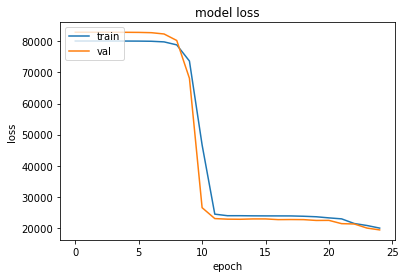

In [23]:
# below the history of training (fitting) the model is plotted
plt.plot(history.history['loss']) # `loss` contains the values of train set losses per epoch
plt.plot(history.history['val_loss']) # `val_loss` contains the values of validation set losses per epoch
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prediction
In this section, the model that is previously fitted will be used to predict the salary ranges for given X values.

In [ ]:
# calculating the predicted Y values for given X values and storing to a variable named `Y_predict`
Y_predict = salary_model.predict(X)
df["predicted_norm_salary_min"] = [y[0] for y in Y_predict] # creating a new column for predicted normalized salary minimum value
df["predicted_norm_salary_max"] = [y[1] for y in Y_predict] # creating a new column for predicted normalized salary maximum value

Below, only the rows belong to the validation set will be displayed to have an overview about the accuracy of the prediction.

In [25]:
val_df = df[:val_len] # taking the rows belong to the validation set
val_df[["title_group", "norm_salary_min", "norm_salary_max", "predicted_norm_salary_min", "predicted_norm_salary_max"]]

,title_group,norm_salary_min,norm_salary_max,predicted_norm_salary_min,predicted_norm_salary_max
2,Data Engineer,47659.898961,59574.873701,71826.898438,90585.484375
3,Data Engineer,83404.823182,107234.772662,82456.648438,103991.554688
4,Data Analyst,90395.071661,90395.071661,69168.421875,87232.718750
6,Data Engineer,77447.335812,89362.310552,78337.117188,98796.000000
7,Data Analyst,59574.873701,95319.797922,65299.953125,82353.781250
...,...,...,...,...,...
379,Data Analyst,32766.180536,38723.667906,59707.093750,75300.257812
380,Data Analyst,90395.071661,117513.593159,68253.085938,86078.187500
384,Data Analyst,81355.564495,103954.332410,62711.257812,79088.960938
385,Data Engineer,59217.424459,74468.592127,60910.320312,76817.718750


## Title - Salary Relation
In this section, as the final stage of the work, the relation between the salary and the title specified in the job openings will be evaluated to see whether there is a relation or not. As the first step, the distribution of the salary ranges per each title will be visualized by drawing a swram plot. For doing this, a library named `seaborn` will be used.

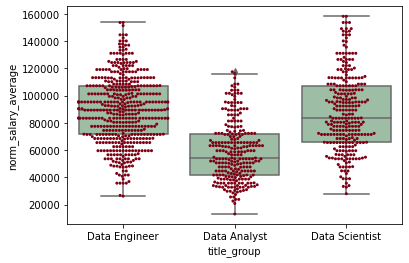

In [26]:
ax = sns.boxplot(x='title_group', y='norm_salary_average', data=df, color='#99c2a2') # draw box plot
ax = sns.swarmplot(x="title_group", y="norm_salary_average", data=df, color='#7d0013', s=3) # draw swarm plot
plt.show()

As seen above, while variances of the salary values of **Data Engineer** and **Data Scientist** job openings are close to each others, the **Data Analyst** is relatively different when compared to the others. To have a numeric insight of the same relation, below, Tukey test is applied to the samples. ANOVA is not applied since the variances are not equal for each of the groups.

In [27]:
res = stat()
res.tukey_hsd(df=df, res_var='norm_salary_average', xfac_var='title_group', anova_model='norm_salary_average ~ C(title_group)')
res.tukey_summary

/Users/suheydaakbay/miniforge3/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Data Engineer,Data Analyst,29995.015329,25496.980399,34493.050259,22.135495,0.001
1,Data Engineer,Data Scientist,750.070110,-3662.886668,5163.026888,0.564203,0.900
2,Data Analyst,Data Scientist,29244.945219,24195.970581,34293.919857,19.226959,0.001


As seen above table of Tukey summary, there is no sensible difference between the salary values of **Data Engineer** and **Data Scientist** as p-values of comparision of these two groups is larger than 0.05. However, there is significant amount of difference between the salary values of **Data Engineer** and **Data Analyst** groups, also the same for **Data Sceientist** and **Data Analyst**, as the p-values are less than 0.05 for these pairs of groups.

## Conclusion
This Coursework was done by aiming to extend the analysis of the job data that scrapped and visualized in the previous Coursework, by using deep learning methods and essential statistical analysis.
- Data samples with outlier or invalid data are removed from the table before continuing to next stages.
- A deep learning model is built for predicating minimum and maximum salary range of a job opening for given description texts.
    - For preprocessing the job description text to make it suitible for applying numerical analysis, tokenization, lemmatization, stopword removing and TF-IDF vectorization are applied.
    - Unit tests are implemented for a function that responsible of vectorization of the texts.
    - As the outcome of the model training, it is seen that there is noise that prevents having a lower loss value in the data set. The effect of the noise could be eliminated by collecting more samples, currently there is around a thousand valid samples in the dataset.
- Tukey test is applied for determining whether there is a relation between job titles and average salaries. As the outcome of applying Tukey test, it is seen that there is a relation between the salaries of job openings with **Data Engineer** and **Data Scientist** titles.

## References

AKBAY, Ş. (2022, March 22). *GitHub - suheydaakbay/uol-msc-ds-python-cw-1*. GitHub.<br/>
Retrieved March 22, 2022, from https://github.com/suheydaakbay/uol-msc-ds-python-cw-1/tree/e9617bb7897e66bc70d0820873aa8b2d117c2c6e

Bedre, R. (2022, March 6). *ANOVA using Python (with examples)*. Data Science Blog.<br/>
Retrieved March 18, 2022, from https://www.reneshbedre.com/blog/anova.html

Brownlee, J. (2020, May 28). *How to Use the Keras Functional API for Deep Learning*. Machine Learning Mastery.<br/>
Retrieved March 18, 2022, from https://machinelearningmastery.com/keras-functional-api-deep-learning/

GeeksforGeeks. (2018, November 22). *Python | Pandas dataframe.quantile()*.<br/>
Retrieved March 18, 2022, from https://www.geeksforgeeks.org/python-pandas-dataframe-quantile/

Prabhakaran, S. (2022, March 8). *Lemmatization Approaches with Examples in Python*. Machine Learning Plus.<br/>
Retrieved March 18, 2022, from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

Wikipedia contributors. (2022, February 16). *Interquartile range*. Wikipedia.<br/>
Retrieved March 18, 2022, from https://en.wikipedia.org/wiki/Interquartile_range